<a href="https://colab.research.google.com/github/mlej8/ECSE552/blob/main/A4/H4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4 - Convolutional Neural Networks



*   **Released**: 23 February, 2021
*   **Due Date**: 9 March, 2021
* **Revisions**: 
  *   **24 Feb, 12:15**: Corrected expected value for Q1.3 from 46 to 33
  *   **26 Feb, 17:02**: There is a discrepancy between the figure in Q1.2 and the question text. Namely, the figure suggest the left half of the window be the larger size, while the text suggests it be the right half. While either will be accepted during grading, to obtain the "expected" value of 33, please defer to the question text (*i.e.*: the right half should be the larger).






In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import math
import matplotlib.pyplot as plt

## 1. Apply Convolution

In this section of the homework, we're going to implement the code required to carry out a two-dimensional convolution on a test image.

## 1.1 Download the Image
The test image can be seen below, and is represented by the variable `test_image`.

In [ ]:
r = requests.get("https://dl.sphericalcow.xyz/ecse552/conv_hmwk/mandrill.tiff")
test_image = Image.open(BytesIO(r.content)).convert('L')
test_image

## 1.2 Extract One Window
Write a function `extract_window` which takes the parameters `image`,`x`, `y`, and `size` and outputs one "window".

You can think of a window as cropping a square of size `size`$\times$ `size` from an image centered on the point given by (`x`, `y`).

This presents a problem if the window size is odd, as there is no true centre. In this case, make the distance between the $(x, y)$ point and the top and the right the largest.

**26 Feb, 17:02**: There is a discrepancy between the figure in Q1.2 and the question text. Namely, the figure suggest the left half of the window be the larger size, while the text suggests it be the right half. While either will be accepted during grading, to obtain the "expected" value of 33, please defer to the question text (*i.e.*: the right half should be the larger).

![odd-sized window](https://dl.sphericalcow.xyz/ecse552/conv_hmwk/mandrill_window.png)



Below is an example of what the output of `extract_window(test_image, 256, 256, 150)` should look like:

![mandrill crop](https://dl.sphericalcow.xyz/ecse552/conv_hmwk/mandrill_crop.png)

In [ ]:
def extract_window(image: Image, x: int, y: int, size: int) -> Image:
  """
  Extracts a square window of size w centered at the point (x,y) from image.
  :param image: The image from which to extract a window
  :param x: The x-coordinate of the point at the center of the window.
  :param y: The y-coordinate of the point at the center of the window.
  :param size: The width and height of the window.

  By the PIL coordinate system, we go by the corners of the pixels, therefore there is no true center if window is odd number of pixels
  """
  # left half of window 
  left_h = bottom_v = math.floor(size/2)
  
  # right half of window should be larger
  right_h = top_v = math.ceil(size/2)
  
  # finding the left top corner indices as for PIL coordinate system
  origin_x, origin_y = x - left_h, y - top_v

  # define box coordinate: the first two values of the box tuple specify the upper left starting position of the crop box. The third and fourth values specify the distance in pixels from this starting position towards the right and bottom direction, respectively.
  box = (origin_x, origin_y, origin_x + size, origin_y + size)

  return image.crop(box)
  
extract_window(test_image, 256, 256, 150)

## 1.3 Convolving the Window

Let's convolve the window we've extracted.

Recall, that the result of a two-dimensional convolution is the sum of the product of a window and a kernel.

Below is a figure from Goodfellow & Bengio which illustrates the convolution operation. You can read more about convolutions in Chapter 9.

![convolution from goodfellow and bengio figure 9.1](https://dl.sphericalcow.xyz/ecse552/conv_hmwk/goodfellow_bengio_9_1.png)

Write a function `conv_window` which takes a window and convolves it with a given kernel.

If we obtain a window `w` of size 3 like so:

```
w = extract_window(test_image, 256, 256, 3)
```

and define a kernel `k` as 

$$
k = \begin{bmatrix}
    1 & 0 & -1 \\
    2 & 0 & -2 \\
    1 & 0 & -1
\end{bmatrix}
$$

then the output of `conv_window(w, k)` should be `33`

In [ ]:
def conv_window(window: Image, kernel: np.array) -> int:
  """
  Convolves a window with a kernel.
  :param window: The window to convolve
  :param kernel: The kernel with which to convolve the window with
  """
  # transform PIL image to numpy
  image_matrix = np.asarray(window)
  
  # element-wise multiplication
  r = image_matrix * kernel

  # return sum of the resulting array
  return r.sum()
  
w = extract_window(test_image, 256, 256, 3)
k = np.array([[1,0,-1],
              [2,0,-2],
              [1,0,-1]])
conv_window(w, k)

## 1.4 Dilated Convolution

Dilated convolutions are a type of convolution which, instead of operating on contiguous pixels, as illustrated below:

![dilated convolution illustration](https://dl.sphericalcow.xyz/ecse552/conv_hmwk/dialated_conv.png)

Dilated convolutions have a "dilation" variable $d$. This dilation variable specifies that the pixels used to convolve a window (in purple, above) are $d-1$ pixels apart. When $d = 1$, this results in "normal" convolutions like the one we just implemented.

Implement a `dilated_conv_window` function which takes as parameters an image, a kernel, and a dilation factor. 

Obtaining a window `w` of size 5 like so:
```
w = extract_window(test_image, 256, 256, 5)
```

and defining a kernel `k` as 

$$
k = \begin{bmatrix}
    1 & 0 & -1 \\
    2 & 0 & -2 \\
    1 & 0 & -1
\end{bmatrix}
$$

the result of `dilation_conv_window(w, k, 2)` should be `-31`

In [ ]:
def dilation_conv_window(window: Image, kernel: np.array, dilation_factor: int) -> int:
  """
  Computes the dilated convolution of a window with a kernel.
  :param window: The window to convolve
  :param kernel: The kernel with which to convolve the window with
  :param dilation_factor: The dilation factor
  """
  # find the dimensions of dilated matrix
  shapes = [s + (dilation_factor-1)*(s-1) for s in kernel.shape]
  
  # create a dilated kernel matrix
  dilated_kernel = np.zeros(shapes)

  # get num of rows and cols in dilated_kernel
  rows, columns = dilated_kernel.shape
    
  for i, j in zip(range(0, rows, dilation_factor), range(len(kernel))):
      # get the row in the dilated_kernel that features values
      arr = dilated_kernel[i]
      
      # get the dilated indices of a row
      dilated_idx = [idx for idx in range(0, columns, dilation_factor)]

      # fill dilated row with values of corresponding row of the kernel
      arr[dilated_idx] = kernel[j]
  
  # transform window into numpy 
  window = np.asarray(window)

  # element-wise matrix multiplication between dilated kernel and window
  r = window * dilated_kernel

  return r.sum()

w = extract_window(test_image, 256, 256, 5)
k = np.array([[1,0,-1],
              [2,0,-2],
              [1,0,-1]])
dilation_conv_window(w, k, 2)

## 1.3 Padding the Image

If we wanted to extract a window centered at pixel $(0,0)$, three quarters of the window would be outside the image, and depending on your implementation, would likely raise an exemption.

To fix this, we'll write a function that can add ``size//2`` to the top, bottom, left, and right of the image. Now, the pixels at the original image are mapped as $(x,y) \to (x+\frac{\textrm{size}}{2}, y+\frac{\textrm{size}}{2})$, so that the original pixel at $(0,0)$ is now mapped to $(\frac{\textrm{size}}{2}, \frac{\textrm{size}}{2})$ in the padded image.

What values should the padded areas have? We can just fill it with zeroes for our purposes.

Implement this padding function in the `zero_pad_image` function below. `zero_pad_image(test_image, 100, 200)` should result in the following image:

![padded mandrill](https://dl.sphericalcow.xyz/ecse552/conv_hmwk/padded_mandrill.png)

In [ ]:
def zero_pad_image(image: Image, pad_size_left_bottom: int, pad_size_top_right: int):
  """
  Adds pads the image `image` by a margin of `pad_size`.
  :param image: The image from which to extract a window
  :param pad_size_left_bottom: The size of the margin to add to the left and bottom margins
  :param pad_size_right_top: The size of the margin to add to the right and top margins
  """
  # get the size of the new image
  old_h, old_w = image.size # old height and width of the image
  new_w = old_w + pad_size_top_right + pad_size_left_bottom # new width
  new_h = old_h + pad_size_left_bottom + pad_size_top_right # new height
  
  # new image 
  new_image = np.zeros((new_h, new_w))
  
  # transform PIL image to numpy
  image_matrix = np.asarray(image)
    
  # move old image into the new image while adding padding
  for row in range(old_h):
    for col in range(old_w):
        new_image[row+pad_size_top_right][col+pad_size_left_bottom] = image_matrix[row][col]

  return Image.fromarray(new_image).convert("L")

plt.imshow(zero_pad_image(test_image, 100, 200), cmap='gray')

## 1.4 Extract Windows

Next, we'll need to extract windows centered on every pixel in the test_image (not counting padded space).

We've implemented this one for you. Provided you've implemented the functions in previous questions as specified, it should work without issue.

In [ ]:
def get_windows(image, window_size):
  """
  Return all square windows centered on every pixel in `image`, of size 
  `window_size`.
  :param image: The image from which to extract all windows
  :param window_size: The size of each window
  """

  original_image_size = image.size
  padded_image = zero_pad_image(image, window_size // 2, window_size - (window_size // 2))

  for x2 in range(original_image_size[1]):
    for x1 in range(original_image_size[0]):
      # the `yield` keyword makes this function a "generator".
      # this allows us to keep the memory use low.
      # you can read more on generators here.
      # https://stackoverflow.com/a/231855
      yield (x1, x2, extract_window(image, x1, x2, window_size))

Here is a quick example of returning the first window and plotting it:

In [ ]:
for x1, x2, window in get_windows(test_image, 5):
  plt.imshow(window, cmap='gray')
  plt.title(f"5x5 Window centered at ({x1}, {x2})")
  break

## 1.5 Convolve the Test Image

Use the `dilation_conv_window` and `get_windows` function to create a new convolved image.

Create a `for` loop to iterate over the windows, apply the `dilation_conv_window` function, and store the results for each window in a new array with the same shape as the original image. This array will become our new image.


The result for `convolve_dilation(test_image, k, 2)` should look like this:

![padded mandrill](https://dl.sphericalcow.xyz/ecse552/conv_hmwk/convolve_result.png)

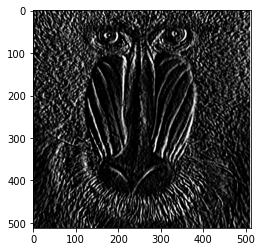

In [51]:
def convolve_dilation(image: Image, kernel: np.array, dilation: int):
  """
  Returns a convolved image given an image and a kernel. Accepts a dialation 
  factor for dialated convolutions.
  :param image: The image to be convolved.
  :param kernel: The kernel to apply.
  :param dilation: The dilation factor. A value of 1 is a "normal" convolution
  """
  # create empty array to store result of dilation convolution
  result = np.zeros(image.size)
  
  # TODO: put some logic to decide minimum window size
  for x1,x2, window in get_windows(image, 5):
      result[x2,x1] = dilation_conv_window(window, kernel, dilation)
  return Image.fromarray(result).convert("L")

plt.imshow(convolve_dilation(test_image, k, 2), cmap="gray")